In [0]:
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.tabular import *

# Rossmann

## Data preparation

upload rossmann_clean.tgz to /content

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!ls -l drive/'My Drive'/'Colab Notebooks'/fastai/dl1/data/rossmann

total 98242
-rw------- 1 root root 18938538 Nov  1 03:05 1.pth
-rw------- 1 root root 18938611 Nov  1 03:05 2.pth
-rw------- 1 root root 54990854 Nov  1 01:35 rossmann_clean.tgz
-rw------- 1 root root  7730448 Nov  1 01:35 rossmann.tgz


In [7]:
!rm -rf /root/.fastai/data/rossmann
!mkdir -p /root/.fastai/data/rossmann
!cp /content/drive/'My Drive'/'Colab Notebooks'/fastai/dl1/data/rossmann/rossmann_clean.tgz /root/.fastai/data && cd /root/.fastai/data && tar xzvf rossmann_clean.tgz


rossmann/
rossmann/df
rossmann/sample_submission.csv
rossmann/googletrend.csv
rossmann/joined
rossmann/train.csv
rossmann/store_states.csv
rossmann/weather.csv
rossmann/store.csv
rossmann/joined_test
rossmann/test.csv
rossmann/state_names.csv
rossmann/test_clean
rossmann/train_clean


To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

### Preparing full data set

In [0]:
train_df = pd.read_pickle(path/'train_clean')
test_df  = pd.read_pickle(path/'test_clean')

procs=[FillMissing, Categorify, Normalize]

cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Days', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

dep_var   = 'Sales'
df        = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()
cut       = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
valid_idx = range(cut)

In [0]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

## Model

In [0]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [19]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(3718, 160)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=383, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_r

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


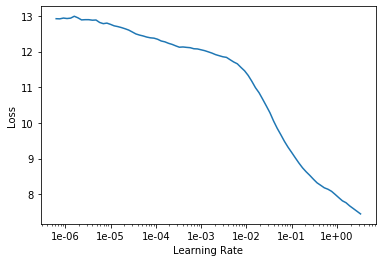

In [22]:
learn.recorder.plot()

In [0]:
learn.save('1')

In [0]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time


In [0]:
learn.save('1')

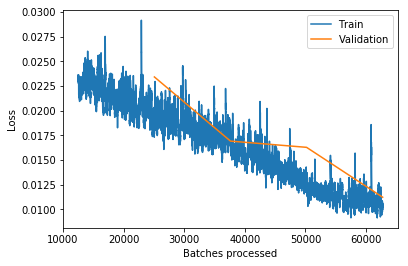

In [0]:
learn.recorder.plot_losses(skip_start=10000)

(10th place in the competition was 0.108)